In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import seaborn as sns
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import initializers
from keras import regularizers

# Модуль формирования модели

In [ ]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

model.add(Dense(256, activation='sigmoid',
                kernel_initializer=initializers.he_normal(seed=None),
                kernel_regularizer=regularizers.l2(l=0.01)))
model.add(Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))

model.layers[0].trainable = False

model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________


# Модуль загрузки данных

In [8]:
# Path to data
data_dir  = 'chest_xray/'
train_dir = data_dir+'train/'
test_dir  = data_dir+'test/'
val_dir   = data_dir + 'val/'

# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir + 'NORMAL/'
pneumonia_cases_dir = train_dir + 'PNEUMONIA/'

print("Datasets:",os.listdir(data_dir))
print("Train:\t", os.listdir(train_dir))
print("Test:\t", os.listdir(test_dir))

Datasets: ['chest_xray', 'test', 'train', 'val', '__MACOSX']
Train:	 ['NORMAL', 'PNEUMONIA']
Test:	 ['NORMAL', 'PNEUMONIA']


NORMAL


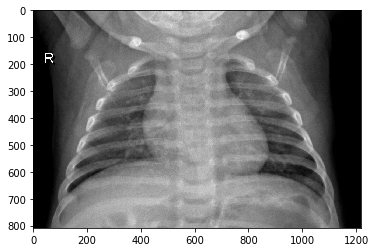

In [9]:
img_name = 'NORMAL2-IM-0588-0001.jpeg'
img_normal = load_img(normal_cases_dir + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

PNEUMONIA


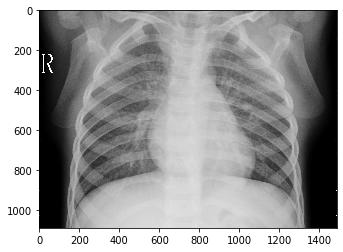

In [10]:
img_name = 'person1044_virus_1740.jpeg'
img_pneumonia = load_img(pneumonia_cases_dir + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

# Модуль формирования и препроцессинга данных

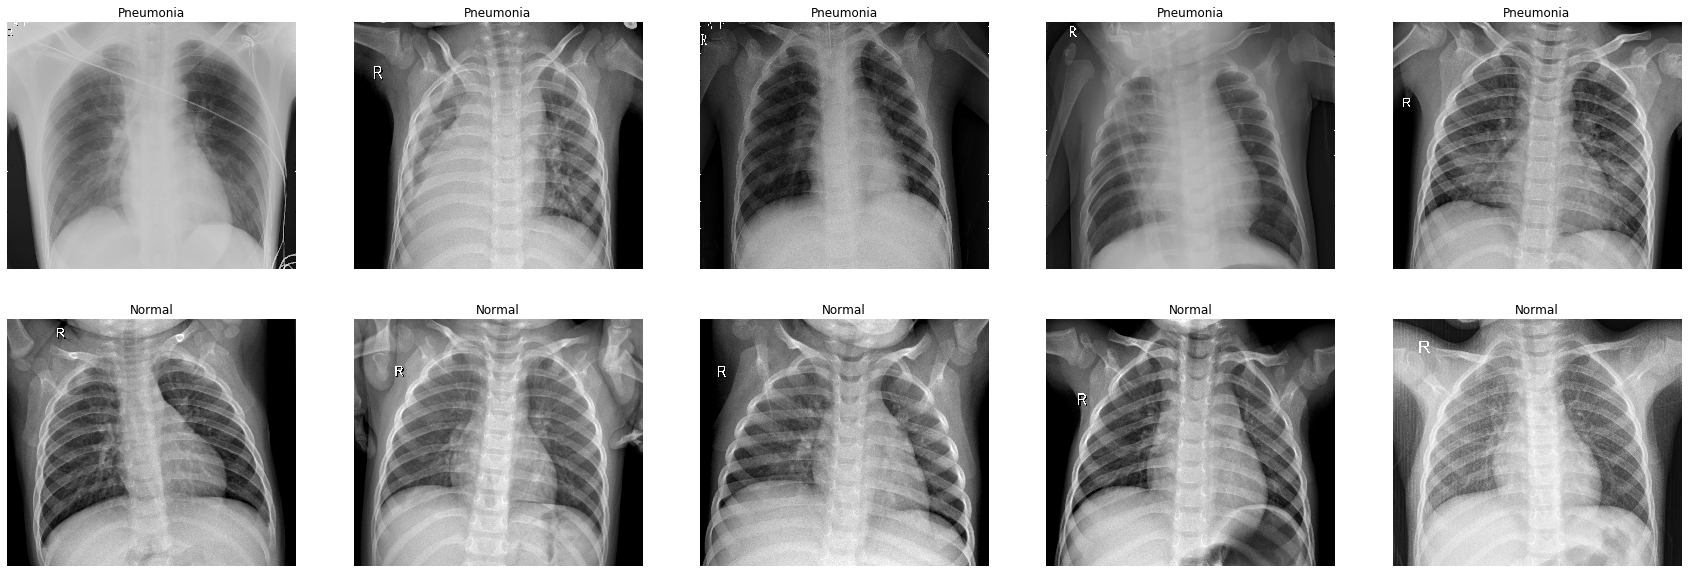

In [11]:
# Get the list of all the images
normal_cases = glob(normal_cases_dir+'/*.jpeg')
pneumonia_cases = glob(pneumonia_cases_dir+'/*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

1    3875
0    1341
Name: label, dtype: int64


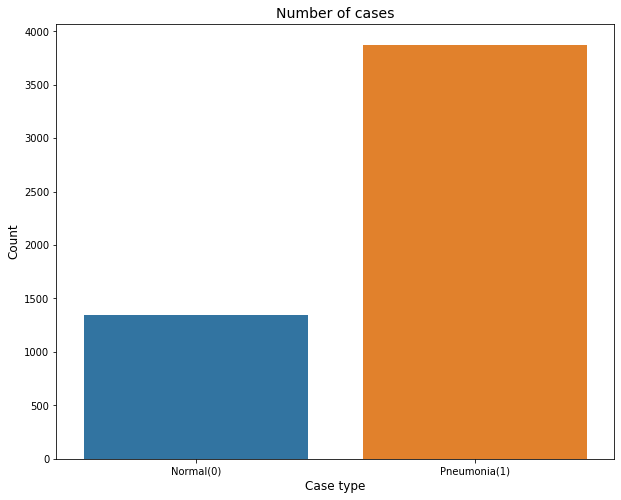

In [13]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [14]:
train_data

,image,label
0,chest_xray/train/NORMAL\IM-0697-0001.jpeg,0
1,chest_xray/train/PNEUMONIA\person1590_bacteria...,1
2,chest_xray/train/PNEUMONIA\person1099_bacteria...,1
3,chest_xray/train/PNEUMONIA\person544_virus_108...,1
4,chest_xray/train/NORMAL\IM-0219-0001.jpeg,0
...,...,...
5211,chest_xray/train/PNEUMONIA\person471_virus_968...,1
5212,chest_xray/train/PNEUMONIA\person257_bacteria_...,1
5213,chest_xray/train/PNEUMONIA\person63_bacteria_3...,1
5214,chest_xray/train/PNEUMONIA\person783_bacteria_...,1


In [ ]:
listdata=train_data.loc[train_data['label']==0].values.tolist()*2)

In [19]:
train_data=train_data.append(pd.DataFrame(listdata, columns=['image','label']),ignore_index=True)

In [20]:
train_data

,image,label
0,chest_xray/train/NORMAL\IM-0697-0001.jpeg,0
1,chest_xray/train/PNEUMONIA\person1590_bacteria...,1
2,chest_xray/train/PNEUMONIA\person1099_bacteria...,1
3,chest_xray/train/PNEUMONIA\person544_virus_108...,1
4,chest_xray/train/NORMAL\IM-0219-0001.jpeg,0
...,...,...
7893,chest_xray/train/NORMAL\NORMAL2-IM-0389-0001.jpeg,0
7894,chest_xray/train/NORMAL\IM-0554-0001.jpeg,0
7895,chest_xray/train/NORMAL\NORMAL2-IM-0831-0001.jpeg,0
7896,chest_xray/train/NORMAL\IM-0757-0001.jpeg,0


In [21]:
train_data = train_data.sample(frac=1.).reset_index(drop=True)
train_data

,image,label
0,chest_xray/train/PNEUMONIA\person333_bacteria_...,1
1,chest_xray/train/NORMAL\NORMAL2-IM-0974-0001.jpeg,0
2,chest_xray/train/NORMAL\IM-0592-0001.jpeg,0
3,chest_xray/train/NORMAL\IM-0441-0001.jpeg,0
4,chest_xray/train/PNEUMONIA\person325_virus_661...,1
...,...,...
7893,chest_xray/train/NORMAL\NORMAL2-IM-1250-0001.jpeg,0
7894,chest_xray/train/NORMAL\IM-0384-0001.jpeg,0
7895,chest_xray/train/PNEUMONIA\person886_bacteria_...,1
7896,chest_xray/train/NORMAL\IM-0429-0001-0002.jpeg,0


0    4023
1    3875
Name: label, dtype: int64


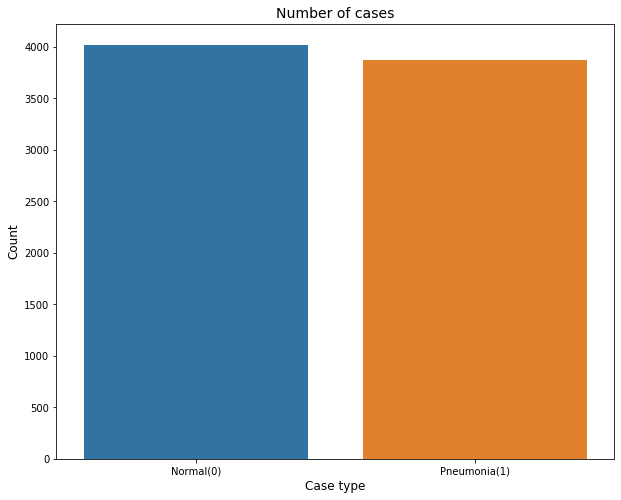

In [22]:
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [23]:
train_datastr=train_data
train_datastr['label']=train_datastr['label'].astype(str)

In [24]:
train_datastr

,image,label
0,chest_xray/train/PNEUMONIA\person333_bacteria_...,1
1,chest_xray/train/NORMAL\NORMAL2-IM-0974-0001.jpeg,0
2,chest_xray/train/NORMAL\IM-0592-0001.jpeg,0
3,chest_xray/train/NORMAL\IM-0441-0001.jpeg,0
4,chest_xray/train/PNEUMONIA\person325_virus_661...,1
...,...,...
7893,chest_xray/train/NORMAL\NORMAL2-IM-1250-0001.jpeg,0
7894,chest_xray/train/NORMAL\IM-0384-0001.jpeg,0
7895,chest_xray/train/PNEUMONIA\person886_bacteria_...,1
7896,chest_xray/train/NORMAL\IM-0429-0001-0002.jpeg,0


In [25]:
image_size = 224
nb_train_samples = len(train_datastr) # number of files in training set
batch_size = 22

EPOCHS =30
STEPS = nb_train_samples / batch_size

## Specify the values for all arguments to data_generator_with_aug.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip = True,
                                             rotation_range=20,
                                             width_shift_range = 0.2,
                                             height_shift_range = 0.2,
                                             shear_range = 0.2,
                                             zoom_range = 0.2)
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_dataframe(
       dataframe=train_datastr,
       directory = '',
       x_col='image',
       y_col='label',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'binary',
       color_mode='rgb')

validation_generator = data_generator_no_aug.flow_from_directory(
       directory = 'chest_xray/val/',
       target_size = (image_size, image_size),
       class_mode = 'binary',
       color_mode='rgb')

test_generator = data_generator_no_aug.flow_from_directory(
       directory = 'chest_xray/test/',
       target_size = (image_size, image_size),
       batch_size = batch_size,
       class_mode = 'binary',
       color_mode='rgb',
       shuffle=False)


Found 7898 validated image filenames belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Модуль обучения

In [26]:
model.fit_generator(
       train_generator, # specify where model gets training data
       epochs = EPOCHS,
       steps_per_epoch=STEPS,
       validation_data=test_generator) # specify where model gets validation data

# Evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/30
359/359 [==============================] - 2556s 7s/step - loss: 5.2999 - acc: 0.8213 - val_loss: 4.9317 - val_acc: 0.7804
Epoch 2/30
359/359 [==============================] - 2413s 7s/step - loss: 4.4527 - acc: 0.9090 - val_loss: 4.2983 - val_acc: 0.7612
Epoch 3/30
359/359 [==============================] - 2389s 7s/step - loss: 3.8485 - acc: 0.9164 - val_loss: 3.7966 - val_acc: 0.7388
Epoch 4/30
359/359 [==============================] - 2391s 7s/step - loss: 3.3428 - acc: 0.9235 - val_loss: 3.2949 - val_acc: 0.8205
Epoch 5/30
359/359 [==============================] - 2399s 7s/step - loss: 2.9138 - acc: 0.9275 - val_loss: 2.9452 - val_acc: 0.7756
Epoch 6/30
359/359 [==============================] - 2404s 7s/step - loss: 2.5486 - acc: 0.9301 - val_loss: 2.5673 - val_acc: 0.8237
Epoch 7/30
359/359 [==============================] - 2391s 7s/step - loss: 2.2217 - acc: 0.9368 - val_loss: 2.3009 - val_acc: 0.8077
Epoch 8/30
359/359 [==============================] - 2392s 7s

In [27]:
from tensorflow.python.keras.models import load_model

In [40]:
model.save('xray_modelresbest30_l2.h5')

In [28]:
#model = load_model('xray_modelresbest30_l2.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Модуль метрик качества модели и визуализации

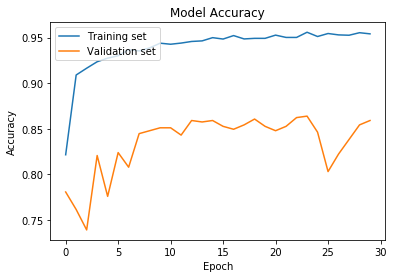

In [27]:
# Accuracy 
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

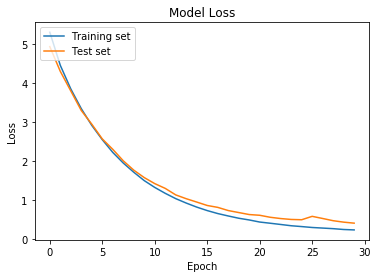

In [28]:
# Loss 
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix

In [131]:
import numpy as np
from sklearn.metrics import roc_auc_score
roc_auc_score(true_classes, pred)


0.9360727591496822

In [29]:
from sklearn.metrics import classification_report
pred = model.predict(test_generator)
true_classes=test_generator.classes

In [151]:
l=list(np.round(np.arange(0,1.01,0.01),2))
spec=[]
rec=[]
prec=[]
acc=[]
pcor=[]
for i in l:
    cm = confusion_matrix(true_classes, pred>i)
    spec.append(cm[0,0]/(cm[0,0]+cm[0,1]))
    rec.append(cm[1,1]/(cm[1,0]+cm[1,1]))
    prec.append(cm[1,1]/(cm[1,1]+cm[0,1]))
    acc.append((cm[1,1]+cm[0,0])/sum(cm.ravel()))
    pcor.append(cm[0,0]/(cm[0,0]+cm[1,0]))
prec[100]=1


C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in longlong_scalars
  del sys.path[0]
C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in longlong_scalars
  # This is added back by InteractiveShellApp.init_path()


In [2]:
thr=np.argmax((np.array(spec)>0.81))/100

NameError: name 'np' is not defined

In [137]:
print(classification_report(true_classes,pred>thr))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       234
           1       0.89      0.89      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



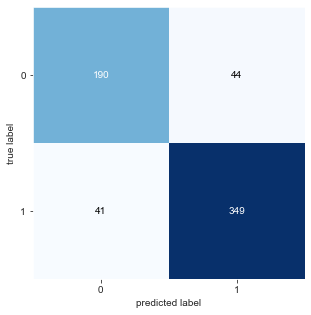

In [140]:
CM = confusion_matrix(true_classes, pred> thr)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM , figsize=(5, 5))
plt.show()

Text(0.5, 0, 'threshold')

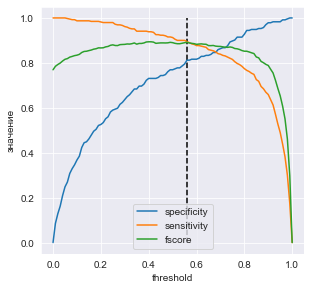

In [154]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,fscore)
plt.vlines(thr, 0,1,ls='--')
plt.legend( ('specificity', 'sensitivity','fscore'))
plt.ylabel('значение')
plt.xlabel('threshold')

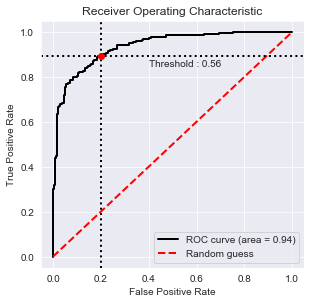

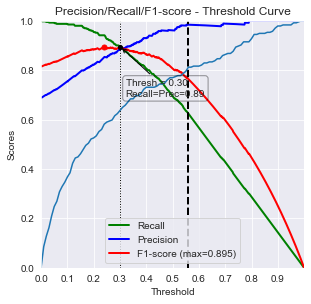

In [155]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(true_classes, pred, labels=["Class 1", "Class 2"],threshold=thr)

# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()

In [35]:
specificity1 = CM[0,0]/(CM[0,0]+CM[0,1])
sensitivity1 = CM[1,1]/(CM[1,0]+CM[1,1])
print('Specificity : ', specificity1)
print('Sensitivity : ', sensitivity1 )

Specificity :  0.9273504273504274
Sensitivity :  0.7743589743589744


In [126]:
fscore=[]
for i in range(len(prec)):
    fscore.append(2*prec[i]*rec[i]/(rec[i]+prec[i]))


In [152]:
print('Чувствительность:',round(rec[56],3))
print('Специфичность:',round(spec[56],3))
print('Точность:',round(acc[56],3))
print('Отношение правдоподобия положительного результата:',round(rec[56]/(1-spec[56]),3))
print('Отношение правдоподобия отрицательного результата:',round((1-rec[56])/spec[56],3))
print('Прогностическая ценность положительного результата:',round(prec[56],3))
print('Прогностическая ценность отрицательного результат:',round(pcor[56],3))
print('Частота ложных срабатываний:',round(1-spec[56],3))
print('AUC ROC:',round(roc_auc_score(true_classes, pred),3))

(0.8948717948717949,
 0.811965811965812,
 0.8637820512820513,
 4.75909090909091,
 0.12947368421052627,
 0.8880407124681934,
 0.8225108225108225,
 0.18803418803418803)

In [1]:
def choose_image_and_predict():
    normal_or_pneumonia = ['NORMAL', 'PNEUMONIA']
    folder_choice = (random.choice(normal_or_pneumonia))
    
    pneumonia_images = glob('chest_xray/val/'+folder_choice+'/*')
    img_choice = (random.choice(pneumonia_images))

    img = load_img(img_choice, target_size=(150, 150))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred = model.predict(x)
    print("Actual class:", folder_choice)
    if pred<=0.56:
        print("Predicted class: Normal")
        print("Prediction:", pred[0][0].round(4))
        if pred[0][0].round(4) > 0.3:
            print("WARNING, low confidence")
    else:
        print("Predicted class: Pneumonia")
        print('Prediction:', pred[0][0].round(4))
        if pred[0][0].round(4) < 0.8:
            print("WARNING, low confidence")        
        
choose_image_and_predict()

NameError: name 'random' is not defined